# 评分标准

- 本次比赛成绩排名根据测试集的在公积金逾期风险监控中，需要尽可能做到尽可能少的误伤和尽可能准确地探测，
于是我们选择“在FPR较低时的TPR加权平均值”作为平均指标。

- 混淆矩阵计算
    TPR（覆盖率）和FPR（打扰率） TPR = TP /（TP + FN） FPR = FP /（FP + TN） 
- 其中，TP、FN、FP、TN分别为真正例、假反例、假正例、真反例。 
- 这里的评分指标，首先计算了3个覆盖率TPR： TPR1：FPR=0.001时的TPR TPR2：FPR=0.005时的TPR TPR3：FPR=0.01时的TPR 
- 最终成绩= 0.4 * TPR1 + 0.3 * TPR2 + 0.3 * TPR3 代码如下：

In [1]:
def tpr_weight_funtion(y_true,y_predict):
    d = pd.DataFrame()
    d['prob'] = list(y_predict)
    d['y'] = list(y_true)
    d = d.sort_values(['prob'], ascending=[0])
    y = d.y
    PosAll = pd.Series(y).value_counts()[1]
    NegAll = pd.Series(y).value_counts()[0]
    pCumsum = d['y'].cumsum()
    nCumsum = np.arange(len(y)) - pCumsum + 1
    pCumsumPer = pCumsum / PosAll
    nCumsumPer = nCumsum / NegAll
    TR1 = pCumsumPer[abs(nCumsumPer-0.001).idxmin()]
    TR2 = pCumsumPer[abs(nCumsumPer-0.005).idxmin()]
    TR3 = pCumsumPer[abs(nCumsumPer-0.01).idxmin()]
    return 0.4 * TR1 + 0.3 * TR2 + 0.3 * TR3

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy import stats
import matplotlib
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import gc
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('expand_frame_repr', False) #数据超过总宽度后，是否折叠显示
pd.set_option('display.width', 100) #数据显示总宽度
pd.set_option('max_rows', 100) #显示最多行数，超出该数以省略号表示
pd.set_option('max_columns', 100) #显示最多列数，超出该数以省略号表示
pd.set_option('max_colwidth', 16) #设置单列的宽度，用字符个数表示，单个数据长度超出该数时以省略号表示
pd.set_option('large_repr', 'truncate') #数据超过设置显示最大行列数时，带省略号显示/若是info则是统计信息显示
pd.set_option('show_dimensions', True) #当数据带省略号显示时，是否在最后显示数据的维度

sns.set_style("whitegrid")
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif' 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.fontsize='20'

In [3]:
# modelling
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

In [4]:
import datetime
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from itertools import combinations
import lightgbm as lgb
# import datatable as dt
# from category_encoders import TargetEncoder
# import optuna

In [5]:
dir_path = './'
file_train = 'train.csv'
file_test = 'test.csv'
file_submit = 'submit.csv'

In [6]:
dtype={
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'str'
}
train = pd.read_csv(dir_path + file_train, dtype=dtype)


![-w1414](https://pu-datacastle.obs.cn-north-1.myhuaweicloud.com/pkbigdata/master.other.img/06777444-a2a5-4ea0-b07f-2bdcc34ea95d.png)

In [7]:
"""

CSNY:时间戳

类别标签
XINGBIE:1,2
HYZK:4种  {90: 39988, 0: 6, 10: 5, 20: 1}
ZHIYE:7种 {90: 39941, 13: 17, 24: 7, 17: 24, 0: 6, 11: 2, 21: 3}

ZHIWU:2种 {0: 39994, 1: 6}
XUELI:2种 {99: 39994, 0: 6}

ZHICHEN:4种 {999: 39926, 8: 67, 99: 1, 0: 6})
DWJJLX:单位经济类型  28种
DWSSHY:单位所属行业  21种
GRZHZT:个人账户状态  5种 {1: 39822, 2: 155, 6: 9, 5: 10, 4: 4}

连续
GRJCJS:个人缴存基数 ？ 个人有工作的情况下，工作第一年以基本工资为个人缴费基数，以后的基数是上年缴费合计的平均数。没有工作的人，以各地的低保标准作为缴费基准。
GRZHYE:个人账户余额
GRZHSNJZYE:个人账户上年结转余额 ？
GRZHDNGJYE:个人账户当年归集余额 ?
GRYJCE:个人月缴存额
DWYJCE:单位月缴存额
DKFFE:贷款发放额
DKYE:贷款余额
DKLL:贷款利率

GRCJBL（个人存缴比例）: 个人月缴存额 / 个人缴存基数
DKJE（贷款金额）: 贷款发放额 * 贷款利率
DKDHJE（贷款待还金额）: 贷款金额 + 贷款余额
DKDHSRBL（贷款待还/收入）: 贷款待还金额 / 个人缴存基数
DKYHJE（贷款已还金额）: 贷款发放额 - 贷款余额
ZYJCE（总月缴存额）: 个人月缴存额 + 单位月缴存额
GRZHZYE（个人账户总余额）: 个人账户余额 + 个人账户上年结转余额 + 个人账户当年归期余额
YEDKDHBL（贷款待还 - 总余额）: 贷款待还金额 - 个人账户总余额
DKSRBL（贷款收入比例）: 贷款发放额 / 个人存缴基数
DKYESRBL（贷款余额收入比例）: 贷款余额 / 个人存缴基数
"""
train.head()

,id,XINGBIE,CSNY,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label
0,train_0,1,1038672000,90,90,999,0,99,150,12,1737.0,1,3223.515,801.310,837.000,312.00,312.00,175237,154112.935,2.708,0
1,train_1,2,504892800,90,90,999,0,99,110,0,4894.0,1,18055.195,53213.220,1065.200,795.84,795.84,300237,298252.945,2.979,0
2,train_2,1,736185600,90,90,999,0,99,150,9,10297.0,1,27426.600,13963.140,7230.020,1444.20,1444.20,150237,147339.130,2.708,0
3,train_3,1,428515200,90,90,999,0,99,150,7,10071.5,1,111871.130,99701.265,2271.295,1417.14,1417.14,350237,300653.780,2.708,0
4,train_4,2,544204800,90,90,999,0,99,900,14,2007.0,1,237.000,11028.875,35.780,325.50,325.50,150237,145185.010,2.708,0


In [8]:
train.info() # 4种

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          40000 non-null  object 
 1   XINGBIE     40000 non-null  int64  
 2   CSNY        40000 non-null  int64  
 3   HYZK        40000 non-null  int64  
 4   ZHIYE       40000 non-null  int64  
 5   ZHICHEN     40000 non-null  int64  
 6   ZHIWU       40000 non-null  int64  
 7   XUELI       40000 non-null  int64  
 8   DWJJLX      40000 non-null  int64  
 9   DWSSHY      40000 non-null  int64  
 10  GRJCJS      40000 non-null  float64
 11  GRZHZT      40000 non-null  int64  
 12  GRZHYE      40000 non-null  float64
 13  GRZHSNJZYE  40000 non-null  float64
 14  GRZHDNGJYE  40000 non-null  float64
 15  GRYJCE      40000 non-null  float64
 16  DWYJCE      40000 non-null  float64
 17  DKFFE       40000 non-null  int64  
 18  DKYE        40000 non-null  float64
 19  DKLL        40000 non-nul

In [9]:
train.describe()

,XINGBIE,CSNY,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label
count,40000.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,1.361900,4.804910e+08,89.974750,89.889300,997.167725,0.000150,98.985150,247.663375,9.612775,4507.734465,1.006300,15020.190993,15316.570595,-117.379254,686.961022,686.961022,190324.265725,156308.760840,2.768083,0.068925
std,0.480868,9.751818e+08,1.461819,2.889914,42.563175,0.012247,1.212422,260.949825,5.541372,2844.622778,0.119836,20189.939168,20061.193795,7968.738147,344.924156,344.924156,75334.858625,77409.960122,0.146709,0.253330
min,0.000000,3.150720e+07,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,787.000000,1.000000,237.000000,237.000000,-240318.745000,246.550000,246.550000,15237.000000,237.000000,2.292000,0.000000
25%,1.000000,3.391776e+08,90.000000,90.000000,999.000000,0.000000,99.000000,110.000000,6.000000,2362.000000,1.000000,1892.468750,2994.080000,-577.803750,411.000000,411.000000,150237.000000,110252.845000,2.708000,0.000000
50%,1.000000,5.205276e+08,90.000000,90.000000,999.000000,0.000000,99.000000,150.000000,10.000000,3887.500000,1.000000,8545.727500,9010.740000,771.800000,616.800000,616.800000,150237.000000,146210.880000,2.708000,0.000000
75%,2.000000,6.338016e+08,90.000000,90.000000,999.000000,0.000000,99.000000,160.000000,14.000000,5831.031250,1.000000,19591.691250,19571.826250,2452.977500,849.060000,849.060000,250237.000000,200844.113750,2.708000,0.000000
max,2.000000,1.903646e+11,90.000000,90.000000,999.000000,1.000000,99.000000,900.000000,20.000000,13692.000000,6.000000,366651.575000,313348.420000,53065.095000,1745.940000,1745.940000,350237.000000,329776.790000,3.575000,1.000000


In [10]:
test=pd.read_csv('test.csv')

In [11]:
test.head()
# HYZK ZHIYE ZHICHEN XUELI DWJJLX 测试集缺值

,id,XINGBIE,CSNY,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL
0,test_0,1,528480000,90,90,999,0,99,159,10,2387.000,1,17146.350,13376.485,1097.000,344.500,344.500,110237,237.000,2.708
1,test_1,1,602265600,90,90,999,0,99,150,11,1237.000,1,3783.385,2145.585,637.000,287.000,287.000,200237,178567.065,2.708
2,test_2,1,31507200,90,90,999,1,99,110,15,5612.904,1,51787.152,35176.592,1115.693,882.108,882.108,150237,146580.203,2.834
3,test_3,2,536428800,90,90,999,0,99,150,10,2977.000,1,785.000,714.885,-2515.105,511.000,511.000,246737,242095.465,2.979
4,test_4,1,86716800,90,90,999,0,99,150,2,4701.500,1,40722.050,27110.840,8163.960,772.740,772.740,100237,72320.445,2.708


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          15000 non-null  object 
 1   XINGBIE     15000 non-null  int64  
 2   CSNY        15000 non-null  int64  
 3   HYZK        15000 non-null  int64  
 4   ZHIYE       15000 non-null  int64  
 5   ZHICHEN     15000 non-null  int64  
 6   ZHIWU       15000 non-null  int64  
 7   XUELI       15000 non-null  int64  
 8   DWJJLX      15000 non-null  int64  
 9   DWSSHY      15000 non-null  int64  
 10  GRJCJS      15000 non-null  float64
 11  GRZHZT      15000 non-null  int64  
 12  GRZHYE      15000 non-null  float64
 13  GRZHSNJZYE  15000 non-null  float64
 14  GRZHDNGJYE  15000 non-null  float64
 15  GRYJCE      15000 non-null  float64
 16  DWYJCE      15000 non-null  float64
 17  DKFFE       15000 non-null  int64  
 18  DKYE        15000 non-null  float64
 19  DKLL        15000 non-nul

In [13]:
column_lianxu = [
    'GRJCJS',
    'GRZHYE',
    'GRZHSNJZYE',
    'GRZHDNGJYE',
    'GRYJCE',
    'DWYJCE',
    'DKFFE',
    'DKYE',
    'DKLL'
]
column_category = [
    'XINGBIE',
    'HYZK',
    'ZHIYE',
    'ZHICHEN',
    'ZHIWU',
    'XUELI',
    'DWJJLX',
    'DWSSHY',
    'GRZHZT'
]

In [14]:
from sklearn.base import BaseEstimator,TransformerMixin

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names]


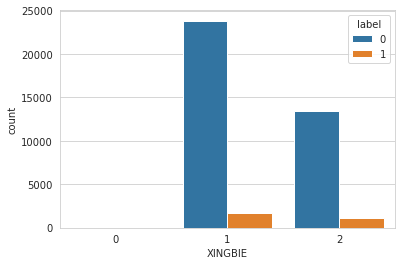

In [19]:
ax = sns.countplot('XINGBIE',hue='label',data = train)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


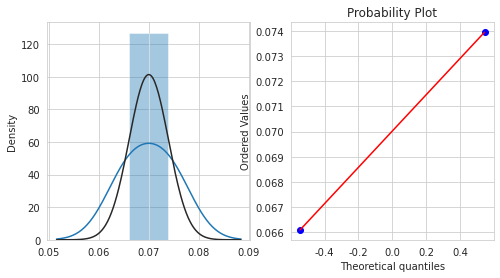

In [15]:
plt.figure(figsize=(8,4))
xingbie_daikuan = [rate for rate in train.groupby(['XINGBIE'])['label'].mean() if rate<=1 and rate>0]

import scipy.stats as stats
ax = plt.subplot(1,2,1)
sns.distplot(xingbie_daikuan,fit=stats.norm)
ax = plt.subplot(1,2,2)
res = stats.probplot(xingbie_daikuan,plot=plt)
# 与性别几乎无关

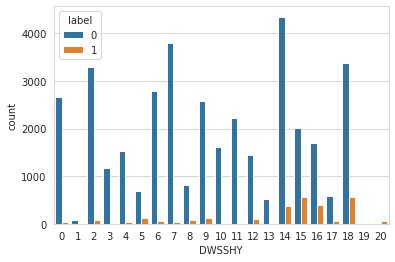

In [20]:
ax = sns.countplot('DWSSHY',hue='label',data = train)

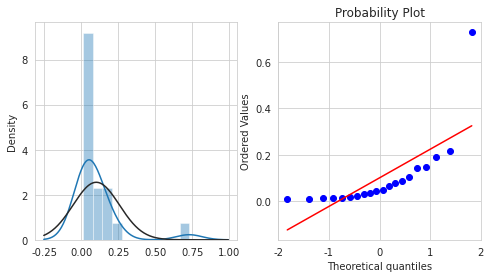

In [16]:
plt.figure(figsize=(8,4))
DWSSHY_daikuan = [rate for rate in train.groupby(['DWSSHY'])['label'].mean() if rate<=1 and rate>0]

ax = plt.subplot(1,2,1)
sns.distplot(DWSSHY_daikuan,fit=stats.norm)
ax = plt.subplot(1,2,2)
res = stats.probplot(DWSSHY_daikuan,plot=plt)
# 行业不同贷款也不同

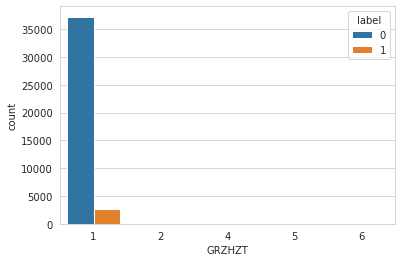

In [21]:
ax = sns.countplot('GRZHZT',hue='label',data = train)

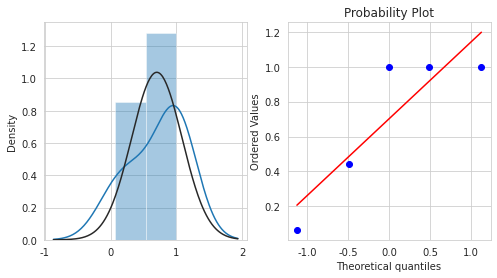

In [17]:
plt.figure(figsize=(8,4))
GRZHZT_daikuan = [rate for rate in train.groupby(['GRZHZT'])['label'].mean() if rate<=1 and rate>0]

ax = plt.subplot(1,2,1)
sns.distplot(GRZHZT_daikuan,fit=stats.norm)
ax = plt.subplot(1,2,2)
res = stats.probplot(GRZHZT_daikuan,plot=plt)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


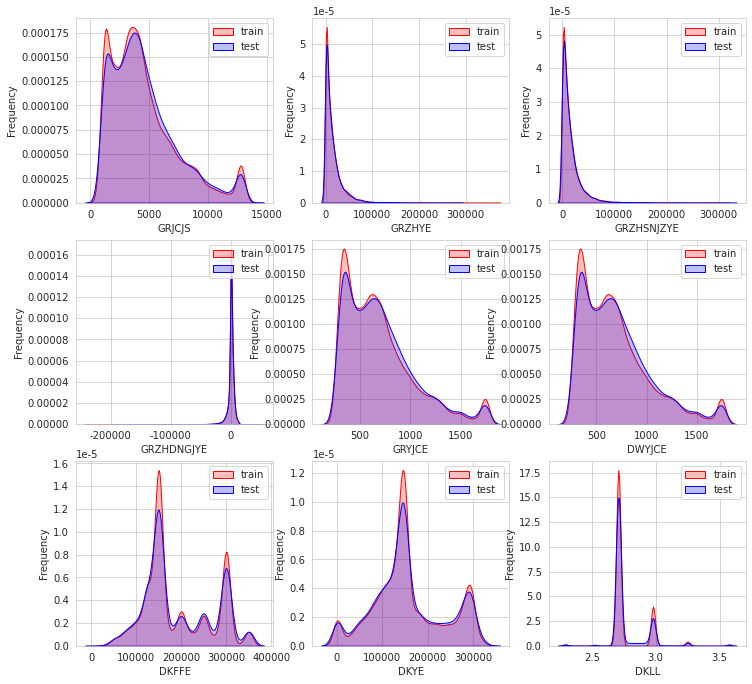

In [15]:
dist_cols = 3
dist_rows = len(column_lianxu)
plt.figure(figsize=(4 * dist_cols, 4 * dist_rows))

lianxu_train = DataFrameSelector(column_lianxu).transform(train)
lianxu_test =  DataFrameSelector(column_lianxu).transform(test)

i = 1
for col in column_lianxu:
    ax = plt.subplot(dist_rows, dist_cols, i)
    ax = sns.kdeplot(lianxu_train[col], color="Red", shade=True)
    ax = sns.kdeplot(lianxu_test[col], color="Blue", shade=True)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax = ax.legend(["train", "test"])

    i += 1
plt.show()

In [16]:
def pie_category(train,test):
    plt.figure(figsize=[9,7])
    train.value_counts().plot.pie()
    print("train:",Counter(train))  
    print("test:",Counter(test))  

train: Counter({1: 25512, 2: 14482, 0: 6})
test: Counter({1: 9826, 2: 5172, 0: 2})


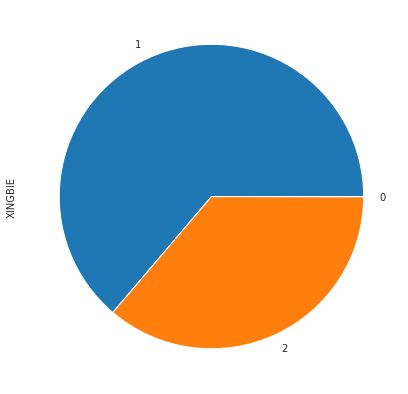

In [17]:
pie_category(train.XINGBIE,test.XINGBIE)  # 6个0 未知

In [18]:
train[train.XINGBIE==0] # 找到他们 

,id,XINGBIE,CSNY,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label
198,train_198,0,310233600,90,90,999,0,99,150,4,2737.000,1,8228.575,15041.030,-3389.500,412.00,412.00,150237,139403.645,2.979,0
19743,train_19743,0,793987200,90,90,999,0,99,150,10,1992.000,1,14755.990,8317.320,1459.980,447.60,447.60,150237,149743.210,2.708,0
23486,train_23486,0,236534400,90,90,999,0,99,170,7,8410.000,1,16706.760,16353.250,-9325.430,890.84,890.84,150237,148277.440,2.708,0
29945,train_29945,0,31507200,90,90,999,0,99,110,18,6449.675,1,10010.525,5499.025,6662.760,982.52,982.52,150237,67640.110,2.708,0
34234,train_34234,0,517935600,90,90,999,0,99,200,3,8300.500,1,2736.100,50638.835,-946.360,1043.35,1043.35,150237,84924.695,2.979,0
36856,train_36856,0,31507200,90,90,999,0,99,150,3,12811.500,1,65562.625,165019.940,-38232.195,1745.94,1745.94,150237,135139.535,2.708,0


train: Counter({99: 39994, 0: 6})
test: Counter({99: 15000})


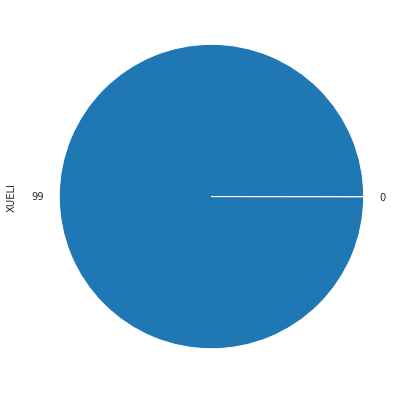

In [19]:
pie_category(train.XUELI,test.XUELI) # 单一数据类型 

In [20]:
train[train.XUELI==0]  # 感觉很多0是未填写的默认值

,id,XINGBIE,CSNY,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label
3649,train_3649,1,533750400,0,0,0,1,0,900,18,4343.0,1,14909.770,368.515,5164.20,729.72,729.72,150237,149990.440,2.708,0
4376,train_4376,1,662659200,0,0,0,1,0,110,9,4237.0,1,8930.200,280.040,237.00,717.00,717.00,300237,297758.005,2.708,0
6556,train_6556,2,625852800,0,0,0,1,0,110,9,1237.0,1,4246.085,1455.710,-10811.46,347.00,347.00,300237,296487.880,2.979,0
9556,train_9556,2,425836800,0,0,0,1,0,110,9,1487.0,1,9050.395,641.180,1737.00,387.00,387.00,85237,83660.305,2.708,0
14501,train_14501,1,712598400,0,0,0,1,0,110,9,2237.0,1,13763.135,1595.075,-1631.88,477.00,477.00,150237,146487.000,2.979,0
16206,train_16206,1,44553600,0,0,0,1,0,110,9,3237.0,1,10564.735,1207.315,-6987.70,597.00,597.00,300237,290717.195,2.708,0


train: Counter({90: 39988, 0: 6, 10: 5, 20: 1})
test: Counter({90: 15000})


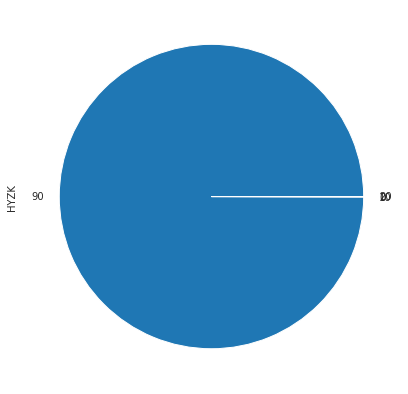

In [23]:
pie_category(train.HYZK,test.HYZK)  #基本上是单一的 0是默认值吧 好多都有6个

In [24]:
train[train.HYZK==0] 

,id,XINGBIE,CSNY,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRJCJS,GRZHZT,GRZHYE,GRZHSNJZYE,GRZHDNGJYE,GRYJCE,DWYJCE,DKFFE,DKYE,DKLL,label
3649,train_3649,1,533750400,0,0,0,1,0,900,18,4343.0,1,14909.770,368.515,5164.20,729.72,729.72,150237,149990.440,2.708,0
4376,train_4376,1,662659200,0,0,0,1,0,110,9,4237.0,1,8930.200,280.040,237.00,717.00,717.00,300237,297758.005,2.708,0
6556,train_6556,2,625852800,0,0,0,1,0,110,9,1237.0,1,4246.085,1455.710,-10811.46,347.00,347.00,300237,296487.880,2.979,0
9556,train_9556,2,425836800,0,0,0,1,0,110,9,1487.0,1,9050.395,641.180,1737.00,387.00,387.00,85237,83660.305,2.708,0
14501,train_14501,1,712598400,0,0,0,1,0,110,9,2237.0,1,13763.135,1595.075,-1631.88,477.00,477.00,150237,146487.000,2.979,0
16206,train_16206,1,44553600,0,0,0,1,0,110,9,3237.0,1,10564.735,1207.315,-6987.70,597.00,597.00,300237,290717.195,2.708,0


In [32]:
train_one_value = [col for col in train.columns if train[col].nunique() <= 1]
test_one_value = [col for col in test.columns if test[col].nunique() <= 1]
print('one value featrues in train:',train_one_value)
print('one value featrues in test: ',test_one_value)

one value featrues in train: []
one value featrues in test:  ['HYZK', 'XUELI']


In [44]:
train.nunique()

id            40000
XINGBIE           3
CSNY            393
HYZK              4
ZHIYE             7
ZHICHEN           4
ZHIWU             2
XUELI             2
DWJJLX           28
DWSSHY           21
GRJCJS        12447
GRZHZT            5
GRZHYE        34927
GRZHSNJZYE    37759
GRZHDNGJYE    31580
GRYJCE        16045
DWYJCE        16045
DKFFE           545
DKYE          21359
DKLL              8
label             2
Length: 21, dtype: int64

In [45]:
test.nunique()

id            15000
XINGBIE           3
CSNY            371
HYZK              1
ZHIYE             4
ZHICHEN           2
ZHIWU             2
XUELI             1
DWJJLX           27
DWSSHY           21
GRJCJS         9891
GRZHZT            5
GRZHYE        13872
GRZHSNJZYE    14559
GRZHDNGJYE    13425
GRYJCE        10615
DWYJCE        10615
DKFFE          1804
DKYE          11275
DKLL            444
Length: 20, dtype: int64

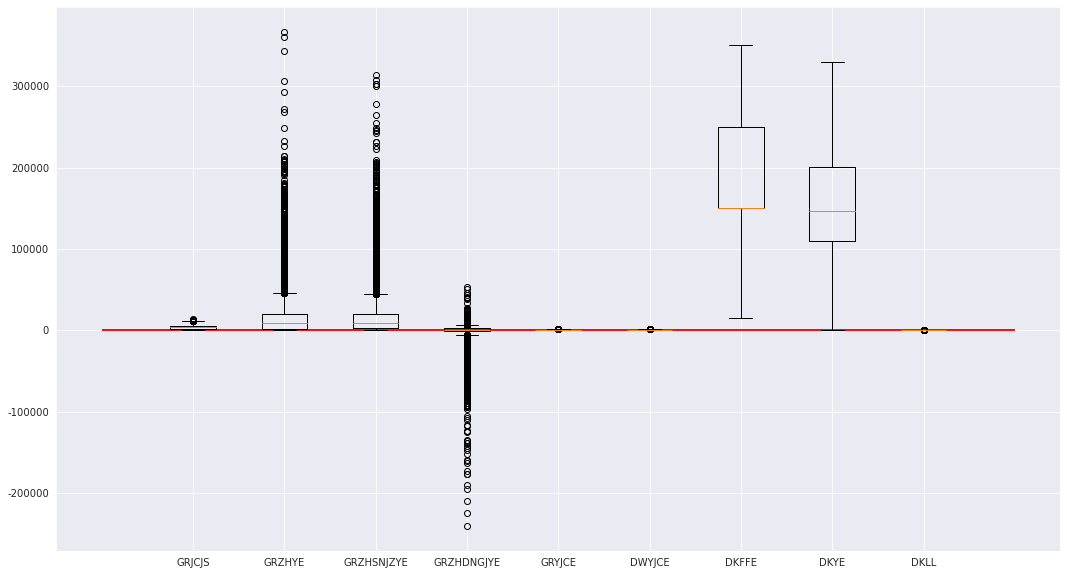

In [41]:
plt.figure(figsize=(18,10))
plt.boxplot(x=lianxu_train.values,labels=lianxu_train.columns)
plt.hlines([-0.5,0.5],0,10,colors='r')

Text(0.5, 1.0, 'Distribution Of Label')

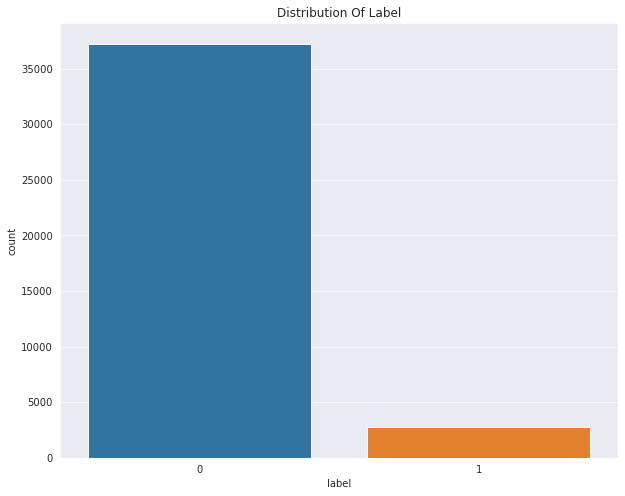

In [46]:
plt.figure(figsize=(10, 8))
sns.countplot(train['label'])
plt.title('Distribution Of Label')

In [54]:
category_train
plt.figure(figsize=(10, 8))
sns.countplot(train['label'])

,XINGBIE,HYZK,ZHIYE,ZHICHEN,ZHIWU,XUELI,DWJJLX,DWSSHY,GRZHZT
0,1,90,90,999,0,99,150,12,1
1,2,90,90,999,0,99,110,0,1
2,1,90,90,999,0,99,150,9,1
3,1,90,90,999,0,99,150,7,1
4,2,90,90,999,0,99,900,14,1
...,...,...,...,...,...,...,...,...,...
39995,1,90,90,999,0,99,110,16,1
39996,2,90,90,999,0,99,110,14,1
39997,2,90,90,999,0,99,143,9,1
39998,1,90,90,999,0,99,150,6,1


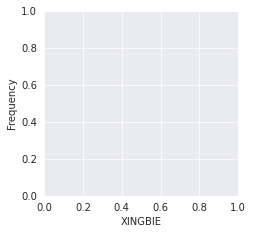

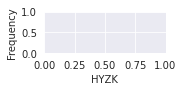

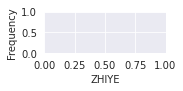

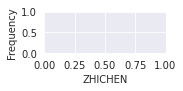

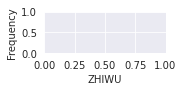

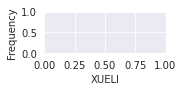

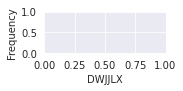

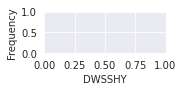

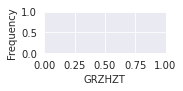

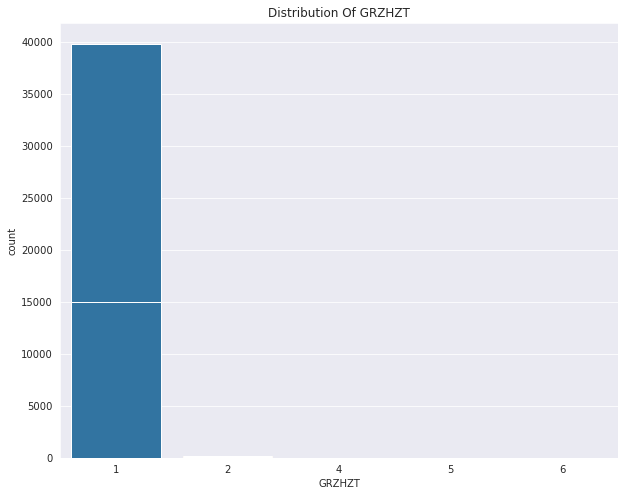

In [53]:
dist_cols = 4
dist_rows = len(column_category)
plt.figure(figsize=(4 * dist_cols, 4 * dist_rows))

category_train = DataFrameSelector(column_category).transform(train)
category_test =  DataFrameSelector(column_category).transform(test)

i = 1
for col in column_category:
    ax = plt.subplot(dist_rows, dist_cols, i)
    plt.figure(figsize=(10, 8))
    sns.countplot(train[col])
    sns.countplot(test[col])
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax = ax.legend(["train", "test"])

    i += 1
plt.show()

<AxesSubplot:title={'center':'Pearson Correaltion of Feature'}>

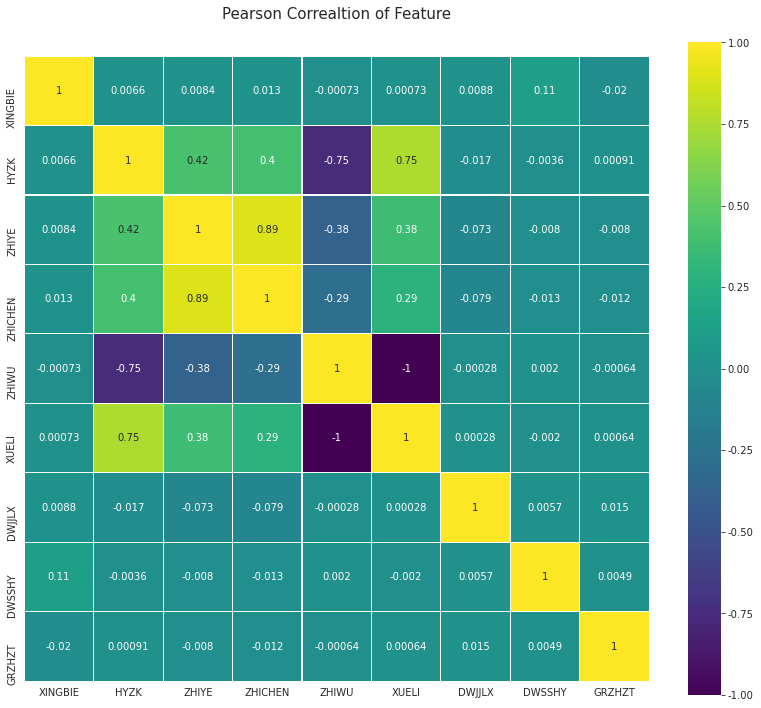

In [49]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correaltion of Feature',y=1.05,size=15)
sns.heatmap(train[column_category].astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True)

In [50]:
train_corr = train.corr()

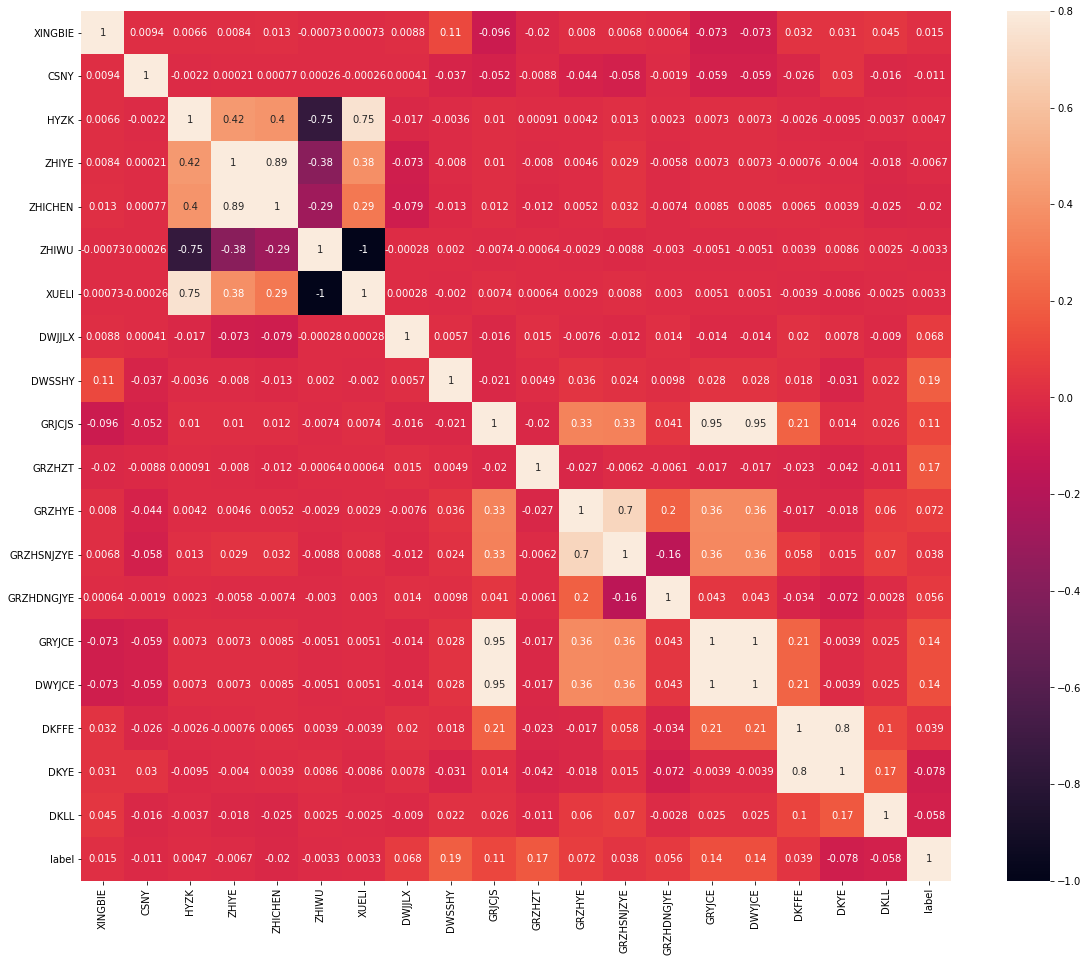

In [97]:
ax = plt.subplots(figsize=(20, 16))#调整画布大小
ax = sns.heatmap(train_corr, vmax=.8, square=True, annot=True)#画热力图   annot=True 显示系数

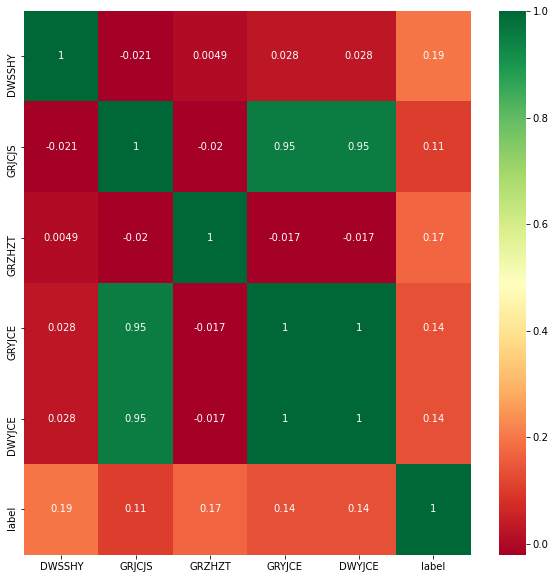

In [104]:
threshold = 0.1

corrmat = train_corr
top_corr_features = corrmat.index[abs(corrmat["label"]) > threshold]
plt.figure(figsize=(10, 10))
g = sns.heatmap(train[top_corr_features].corr(),
                annot=True,
                cmap="RdYlGn")